In [1]:
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from cospar import reader, F, paramkeys, datakeys, highlight_case
from everest.analysis import time_fourier
from everest.window import Canvas
from everest.window.data import Data
%matplotlib inline

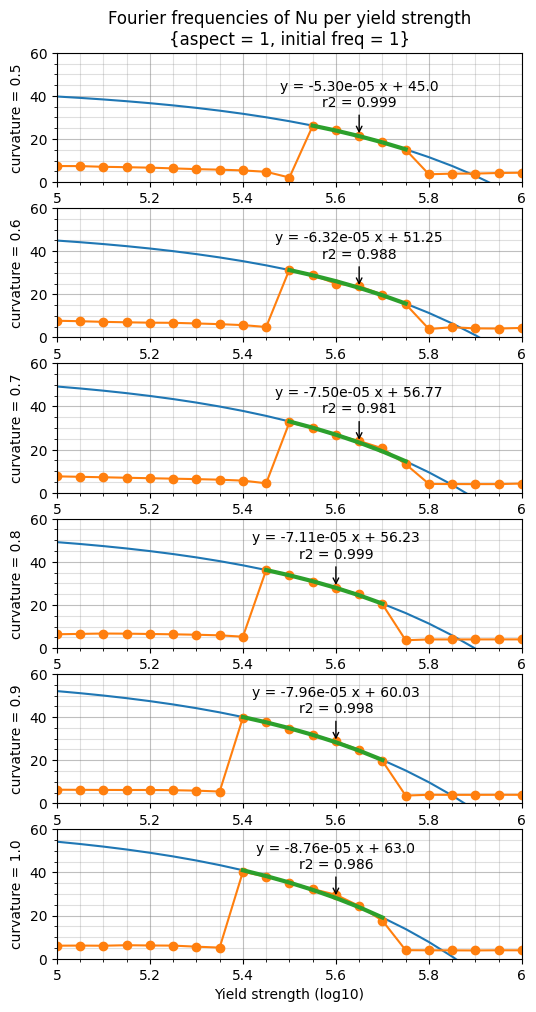

In [25]:
canvas = Canvas(size = (6, 12), shape = (6, 1))

fs = (0.5, 0.6, 0.7, 0.8, 0.9, 1.0)
slopes, intercepts = [], []

for rowNo, f in enumerate(fs):

    aspect = 1
    colNo = 0

    cut = reader[
        (F('f') == f) \
        & (F('aspect') == aspect) \
        & (F('temperatureField') == '_built_peaskauslu-thoesfthuec') \
        ]
    datas = sorted(reader[cut : ('tauRef', 't', 'Nu')].values())

    domFreqs = np.empty(len(datas))
    tauRefs = np.empty(len(datas))
    for i, (tauRef, t, Nu) in enumerate(datas):
        mask = t > (max(t) - max(t) * 2 ** -1.5)
        tauRefs[i] = tauRef
        freqs, trans = time_fourier(
            t[mask],
            Nu[mask],
            sampleFactor = 10,
            interpKind = 'quadratic',
            minFreq = 0.01,
            maxFreq = 50,
            minAmps = (1.5,),
            )
        domFreqs[i] = freqs[list(trans).index(np.max(trans))]

    mask = domFreqs > 10
    eoTaus, eoFreqs = tauRefs[mask], domFreqs[mask]
    linreg = LinearRegression().fit(eoTaus.reshape(-1, 1), eoFreqs)
    predFreqs = linreg.predict(eoTaus.reshape(-1, 1))
    r2 = r2_score(eoFreqs, predFreqs)
    slope, intercept = linreg.coef_, linreg.intercept_
    extrapFreqs = linreg.predict(tauRefs.reshape(-1, 1))

    ax = canvas.make_ax(place = (rowNo, colNo))
    x = Data(np.log10(tauRefs), label = 'Yield strength (log10)', lims = (5, 6), capped = (True, True))
    ax.line(
        x,
        Data(extrapFreqs, lims = (0, 60)),
    #     marker = 'o'
        )
    ax.line(
        x,
        Data(domFreqs, lims = (0, 60)),
        marker = 'o'
        )
    ax.line(
        np.log10(eoTaus),
        Data(predFreqs, lims = (0, 60)),
        linewidth = 3,
    #     marker = 'o'
        )
    ax.grid.colour = 'grey'
    slopeformat = "{:.2e}".format(slope[0])
    label = f"y = {slopeformat} x + {round(intercept, 2)}\nr2 = {round(r2, 3)}"
    ax.annotate(
        *list(zip(np.log10(eoTaus), predFreqs))[round(len(predFreqs) / 2)],
        label,
        points = (0, 30),
        arrowProps = {'arrowstyle': '->', 'color': 'black'},
        )
    if rowNo != 5:
        ax.axes.x.label = ''
#         ax.ticks.x.major.labels = []
    if rowNo == 0:
#         ax.axes.title = f"aspect = {aspect}"
        ax.axes.title = 'Fourier frequencies of Nu per yield strength\n{aspect = 1, initial freq = 1}'
    if colNo == 0:
        ax.axes.y.label = f"curvature = {f}"

    slopes.append(slope[0])
    intercepts.append(intercept)

canvas.show()

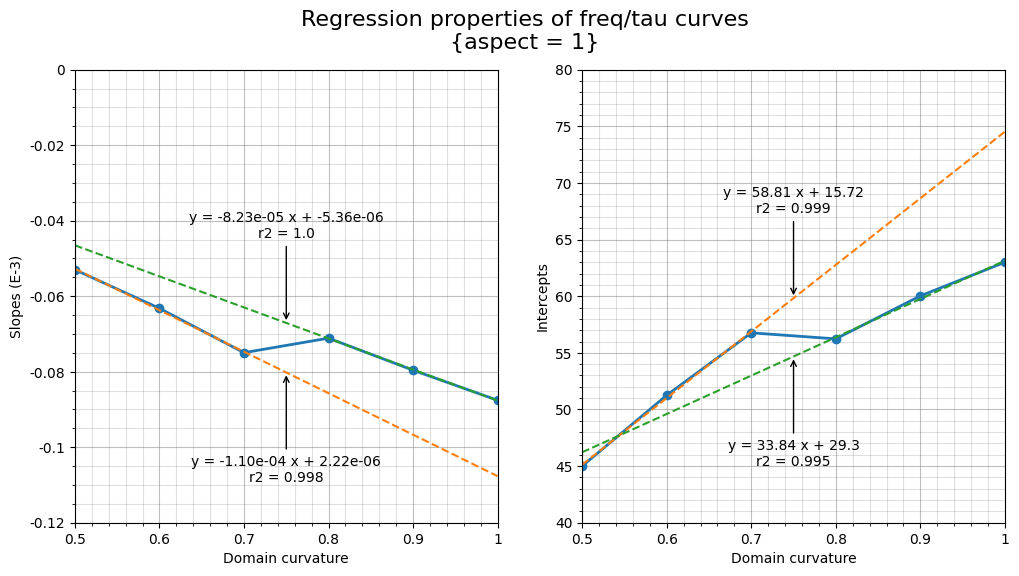

In [24]:
fs = np.array(fs)
slopes = np.array(slopes)
intercepts = np.array(intercepts)

canvas = Canvas(size = (12, 6), shape = (1, 2), title = 'Regression properties of freq/tau curves\n{aspect = 1}')
ax1 = canvas.make_ax(place = (0, 0))
ax2 = canvas.make_ax(place = (0, 1))
x = Data(fs, label = 'Domain curvature', lims = (0.5, 1.), capped = (True, True))

for ax, d, label in zip((ax1, ax2), (slopes, intercepts), ('Slopes', 'Intercepts')):

    ax.line(
        x,
        Data(d, label = label),
        marker = 'o',
        linewidth = 2,
        )
    ax.grid.colour = 'grey'

    for i, inds in enumerate(([0, 1, 2], [3, 4, 5])):
        linreg = LinearRegression().fit(fs.reshape(-1, 1)[inds], d[inds])
        pred = linreg.predict(fs.reshape(-1, 1))
        ax.line(
            x,
            Data(pred),
            linestyle = '--'
            )
        slope, intercept = linreg.coef_[0], linreg.intercept_
        slopeformat = "{:.2e}".format(slope) if not (1 < slope < 999) else round(slope, 2)
        interceptformat = "{:.2e}".format(linreg.intercept_) if not (1 < intercept < 999) else round(intercept, 2)
        r2 = r2_score(d[inds], pred[inds])
        label = f"y = {slopeformat} x + {interceptformat}\nr2 = {round(r2, 3)}"
        labely = linreg.predict([[0.75]])[0]
        ax.annotate(
            0.75,
            labely,
            label,
            points = (0, 70 if labely > d[2] else -70),
            arrowProps = {'arrowstyle': '->', 'color': 'black'},
            )

canvas.show()